# Dígitos MNIST

Vamos a hacer una tarea muy típica. Utilizaremos los datos de MNIST. MNIST es un organismo que tiene muchos datos. No obstante, aquí nos referimos a un dataset en el que tenemos dígitos de postales.

Estos dígitos son imágenes de 28x28. Cada píxel tiene un valor de 0 a 255 (0:blanco, 1:negro). Además la imagen tiene una etiqueta que es el número que aparece en la imagen. Esta etiqueta se ha puesto manualmente.

Son 60.000 imágenes de train y 10.000 imágenes de test.

In [1]:
%pylab inline
plt.style.use('seaborn-talk')

Populating the interactive namespace from numpy and matplotlib


We will use this function to plot the metrics of our training process, to help in choosing the best model

In [0]:
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show()  

We will use this function to explore the data

In [0]:
def plot_mnist_image(N, imgs, labels):
  print("The image below should show the number %d" % labels[N])
  plt.imshow(imgs[N,], cmap=plt.cm.binary)
  plt.grid(True)

# The problem

We will recognize handwritten digits. For an image containing a number between 0 and 9, we will recognize the number and will produce an int as output

In [4]:
# El dataset está incluido en keras
from keras.datasets import mnist

Using TensorFlow backend.


In [0]:
# Run this to download the data prior to the lecture
train_orig_data, test_orig_data = mnist.load_data()

Nota: para tunear los hiperparámetros tenemos que dividir en train-validation-test o hacer validación cruzada. En este ejemplo lo dividiremos en train-validation-test.

Vamos a analizar los datos:

In [0]:
imgs_train_orig, label_train_orig = train_orig_data
imgs_test_orig, label_test_orig = test_orig_data

In [8]:

type(imgs_train_orig)

numpy.ndarray

In [9]:
imgs_train_orig.shape

(60000, 28, 28)

Esto es un tensor, una lista de 60.000 matrices (imágenes en este caso)

In [11]:
label_train_orig.shape

(60000,)

The image below should show the number 3


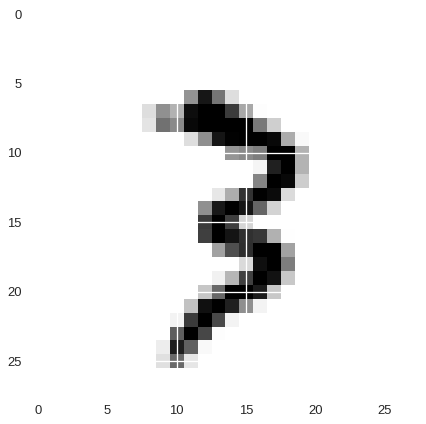

In [13]:
plot_mnist_image(25000, imgs_train_orig, label_train_orig)

We will design a network that will be able to recognize that the image is showing the number 7 (for all the images in the test set)

Ahora tenemos que decidir qué red neuronal vamos a usar. Vamos a utilizar una de capas densas (aunque para imágenes hay métodos más adecuados). No obstante, para utilizar una red así necesitamos que los inputs sean vectores.

Necesitamos vectores de 728x1.

También podríamos meter una capa especial `flatten` que tiene `keras` y que hace esto.

Si no hacemos esto, no hay manera de que las multiplicaciones cuadren y no se puede entrenar la red.

## Data transform

We need to change the shape of the data, so it can be fed to the network more easily

In [0]:
j = imgs_train_orig[523]

In [15]:
j.shape

(28, 28)

In [16]:
j[:3][:3]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]], dtype=uint8)

In [0]:
# Transformamos
t = j.reshape((784,))

In [18]:
t.shape

(784,)

In [19]:
t[490:500]

array([105, 255, 225,  17,   0,   0,   0,   0,   0,   0], dtype=uint8)

All the images are 28x28 matrices, with values between 0 and 255. Let's normalize the images, to avoid problems in the numerical computations using large numbers.

We will convert the matrix to a vector with 28x28 components, stacking columns on top of each other. This will make the design of the network.
* Alternatively, we could add a `Flatten(input_shape=(28,28))` layer to the model

Vamos a aplicar esto a todos los datos (train y test):

In [0]:
imgs_train_t = imgs_train_orig.reshape((60000, 28*28))  # 60000 filas, 784 columnas. Cada fila será una imagen
imgs_test_t = imgs_test_orig.reshape((10000, 28*28))

In [21]:
imgs_train_t[523][:25]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=uint8)

In [22]:
print(imgs_train_t[523].max())
print(imgs_train_t[523].min())

255
0


Como en la GPU con números grandes podemos tener problemas numéricos (por ejemplo redondeos). Vamos a normalizar de alguna manera. En este caso, dividiremos entre 255.

In [0]:
imgs_train_t = imgs_train_orig.reshape((60000, 28*28))/255
imgs_test_t = imgs_test_orig.reshape((10000, 28*28))/255

Una de las ventajas de una red neuronal es que no hay que hacer feature engineering, ya que la red selecciona automáticamente las features que son importantes. No hay problemas de colinealidad, múltiples dimensiones, etc...

Aquí las features son los 784 píxeles.

Because we want to assign a *category* to each image, we need to transform the output to categorical format

En problemas de clasificación, el vector output siempre suele ser así: un vector con 0 y el 1 en la clase. Porque si de output tuviéramos un escalar, nos va a predecir valores continuos. Y no queremos.

In [24]:
label_train_orig[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

Initially, our target data is just a set of numbers

We are going to transform it to **1-HOT encoding format**

In [0]:
from keras.utils import to_categorical

label_train_t = to_categorical(label_train_orig)
label_test_t = to_categorical(label_test_orig)

We have to repeat the same process with the test data

In [26]:
label_train_orig[5]

2

In [27]:
label_train_t[5]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Let's build the model

In [0]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

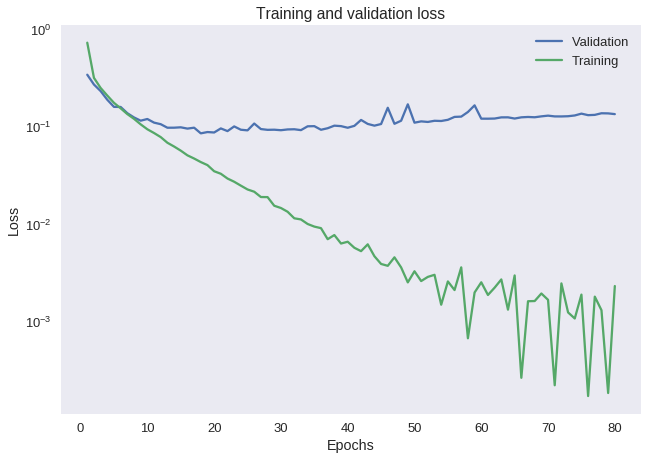

In [29]:
# Construimos el modelo

# Tipo
m = models.Sequential()

# Capas
m.add(layers.Dense(128, input_shape=(784,), activation='relu'))  # 128 por probar, relu porque es la que funciona bien en el caso general
m.add(layers.Dense(64, activation='relu'))  # porque sí
m.add(layers.Dense(10, activation='softmax'))  # en el caso de clasificación, la función de activación de la salida sí que hay que elegirla en función del problema. Ahora queremos probabilidad: softmax(multinomial)

# Optimizador, loss y métricas
m.compile(
          optimizer=optimizers.rmsprop(),  # SGD normal
          loss=losses.categorical_crossentropy,
          metrics=[metrics.categorical_accuracy])

# Fitteamos
h = m.fit(imgs_train_t, label_train_t, epochs=80, batch_size=1024, validation_split=.2, verbose=0)

# Plot
plot_metric(h, 'loss')

Hay overfitting. El validation error sube, a pesar de que el training baje. Vamos a ponerle 30 épocas

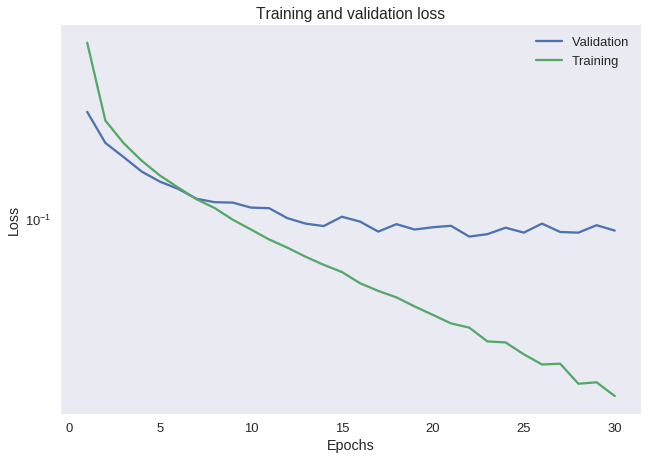

In [30]:
# Construimos el modelo

# Tipo
m = models.Sequential()

# Capas
m.add(layers.Dense(128, input_shape=(784,), activation='relu'))  # 128 por probar, relu porque es la que funciona bien en el caso general
m.add(layers.Dense(64, activation='relu'))  # porque sí
m.add(layers.Dense(10, activation='softmax'))  # en el caso de clasificación, la función de activación de la salida sí que hay que elegirla en función del problema. Ahora queremos probabilidad: softmax(multinomial)

# Optimizador, loss y métricas
m.compile(
          optimizer=optimizers.rmsprop(),  # SGD normal
          loss=losses.categorical_crossentropy,
          metrics=[metrics.categorical_accuracy])

# Fitteamos
h = m.fit(imgs_train_t, label_train_t, epochs=30, batch_size=1024, validation_split=.2, verbose=0)

# Plot
plot_metric(h, 'loss')

Nos quedamos con este modelo. Recordemos que estamos plotteando la loss (crossentropy). Vamos a ver la accuracy:

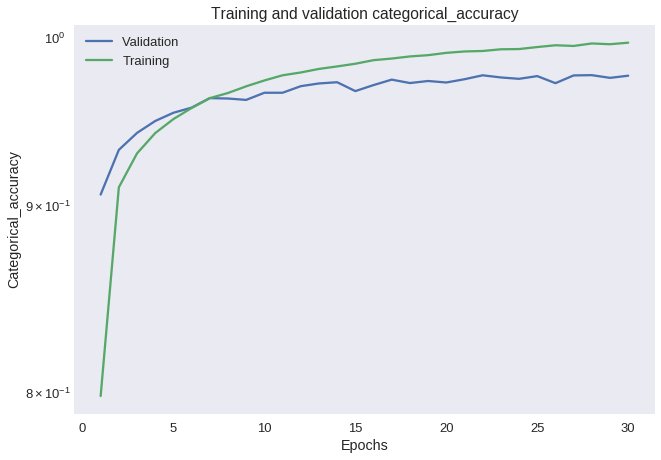

In [31]:
plot_metric(h, 'categorical_accuracy')

* Loss: En clasificación, podemos coger `crossentropy` o `hinge`. En este caso cogemos `crossentropy`.
* Métricas: utilizaremos el accuracy

Vamos a evaluar el modelo sobre el test set. Ahora lo que hemos hecho es probar con diferentes hiperparámetros y hemos llegado a una conclusión. Ahora, vamos a ver realmente cómo de bueno es nuestro modelo en datos que nunca ha visto.

In [32]:
m.evaluate(imgs_test_t, label_test_t)

10000/10000 [==============================] - 1s 100us/step


[0.08288894221100782, 0.9786]

El accuracy en el conjunto de test es de un 97.39%.

Una buena práctica es ver dónde comete fallos (por ejemplo, que se equivoque con los 7 y los 1).

Here we will make some decisions about how to train our model.

The **objective function**, called **loss function** in Deep Learning, will be *categorical crossentropy*. This is because we are trying to predict discrete classes. If we choose a different function, the solution will be different. This is the function that will tell us when we have found the *solution*. Different functions will point to different *solutions*.

The **optimizer** is the method that we will use to find the minimum of the **loss function**. In general, we will not find the global minimum of the loss function, but a minimum that is good enough. *RMSProp* is one the variants of gradient descent. But there are many more:
 - http://ruder.io/optimizing-gradient-descent/
 
These two settings will define what solution we will find during the training process.

The other parameter, the **metrics**, is only for information purposes. In each step of the training (called **epoch**), Keras will report the value of the metrics. But whether we choose one metric or another will not influence the training process. It is only for reporting how the training is going. That information will be useful for the validation of the model, that is, for the **hyperparameters tuning**.


Now let's fit the neural network. We will keep the results in a *history* object to plot some parameters after the training, and use that information for improving our model (changing layers, activation functions, etc). This process is called **hyperparameters tuning** or hypeparameters search.

Here we need to set two parameters: the number of **epochs** and the **batch size**.

In previous cells, I have said that the training process is an optimization problem: we try to find the minimum.

That's actually not entirely true. In practice, we don't keep searching for a minimum. Instead, we train for a preset number of epochs. Then we analyze the output using the validation set. If we detect overfit, then we reduce the number of epochs. If we don't detect it, then maybe we can keep going for some more epochs to find a better model. The number of epochs is another hyperparameter. In general, we should stop the training as early as possible. Any further epoch can make our model overfit, and therefore generalize poorly.

The batch size is another hyperparameter. The network is not updated item by item, vector by vector. We can actually calculate the weights for a batch of several items, forming a matrix or a tensor. The batch size will affect the granularity of the calculations and the performance. A larger batch size will probably result in a slightly worse accuracy, but in a better performance. As long as the batch size is not so huge that it cannot be kept in memory. Because we are running on a GPU, it is a good idea to use a power of 2 for the batch size. It will probably make a better use of the GPU. But again, the effect of the batch size must be tested using the validation set, and adjusted until we find a good value for that parameter.

An epoch is a full pass over the training dataset. At the end of each epoch, Keras will calculate the value of the metrics for the training set, and the loss function and metrics for the validation set. The loss and metrics of the validation set are useful for the hyperparameters tuning process.



## Exercises

* **EXERCISE 1**: Chante the activation function in the model. How does it affect accuracy? What happens if you use linear activation function? What happens if we use the $\tanh$ function? Does it affect to overfitting?
 * https://keras.io/activations/
 
Here we see that the accuracy keeps increasing over epochs. An overfitted model would produce a decrease of the validation accuracy at some point. This means that we have found an optimal model. The validation loss is stuck at a minimum, but the accuracy is not affected by the extra epochs.

_**EXERCISE 2**_: How is the model accuracy (measured with the test set, see below) affected if we start over and fit for 40 epochs? And for 4? And for 400?

_**EXERCISE 4**_: What is the most simple model that you can get that achieves a similar validation performance (accuracy)? (the loss values are not comparable, different networks will have different ranges of values for the loss functions)

Now let's check how well the model works with the test dataset. Remember that we don't have used it at all during the training and tuning of the model.

## Analyze the classification performance

In [33]:
_, acc = m.evaluate(imgs_test_t, label_test_t)

10000/10000 [==============================] - 1s 116us/step


That's about a $98\%$ accuracy on the test set. Not bad.

With that accuracy, this is the number of images that are wrongly classified by our model:

In [34]:
(1 - acc)*imgs_test_t.shape[0]

213.99999999999974

Pero en qué falla nuestro modelo? Qué cosas le cuestan más? Hay errores sistemáticos? Todo esto hay que verlo a la hora de hacer un modelo.

Let's see how well it predicts some random items from the test set.

The image below should show the number 8


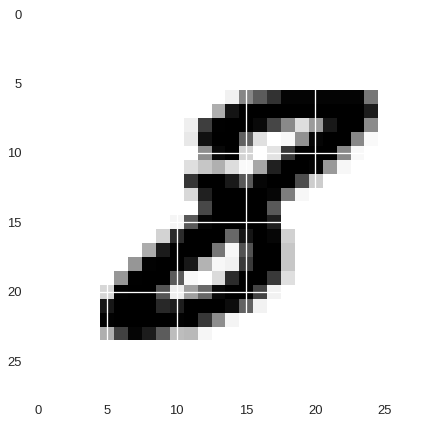

In [35]:
plot_mnist_image(2543, imgs_test_orig, label_test_orig)

The prediction is a 10-element vector (*1-HOT encoded vector*), with the probability of each class. The location of the max is giving us the predicted class.

In [36]:
np.argmax(m.predict(imgs_test_t[2543:2544]))  # es el 2543, pero así le estamos pasando el tensor

8

YES! Our model predicts 8

_**EXERCISE 5**_: Can you find a test item that is predicted wrongly? How many images are predicted wrongly? Can you find all the items that are wrongly classified? For instance, the test element with index 3943 is a 3 but we predict a 5

Vamos a ver las que ha predicho mal

In [37]:
# Obtenemos las predicciones
preds = np.argmax(m.predict(imgs_test_t), axis=1)

print(preds.shape)

print(preds[3])

(10000,)
0


Vamos a ver cuándo nos equivocamos

In [38]:
pos = (preds == label_test_orig)
pos[:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [39]:
pos = np.where(preds != label_test_orig, )
pos

(array([  61,  247,  259,  321,  340,  445,  495,  551,  582,  619,  659,
         684,  691,  717,  720,  947,  951,  956,  965, 1014, 1039, 1112,
        1128, 1181, 1182, 1226, 1232, 1242, 1247, 1319, 1378, 1393, 1433,
        1494, 1522, 1530, 1549, 1553, 1609, 1678, 1681, 1717, 1754, 1800,
        1828, 1850, 1878, 1901, 1984, 2004, 2043, 2044, 2053, 2073, 2098,
        2109, 2118, 2135, 2182, 2272, 2293, 2387, 2414, 2462, 2607, 2648,
        2654, 2730, 2810, 2877, 2896, 2915, 2921, 2930, 2939, 2953, 3005,
        3060, 3073, 3117, 3490, 3503, 3520, 3558, 3567, 3597, 3604, 3662,
        3702, 3727, 3749, 3751, 3757, 3769, 3776, 3780, 3796, 3808, 3811,
        3838, 3853, 3869, 3893, 3902, 3906, 3926, 3943, 4065, 4075, 4078,
        4123, 4140, 4154, 4163, 4176, 4199, 4207, 4224, 4248, 4289, 4294,
        4369, 4384, 4419, 4425, 4433, 4497, 4508, 4536, 4548, 4731, 4807,
        4823, 4860, 4880, 4956, 4966, 5199, 5331, 5457, 5600, 5642, 5676,
        5734, 5749, 5887, 5936, 5937, 

Estas son las posiciones en las que mi modelo no ha acertado.

In [40]:
pos[0].shape  # 214 fallos

(214,)

The image below should show the number 8


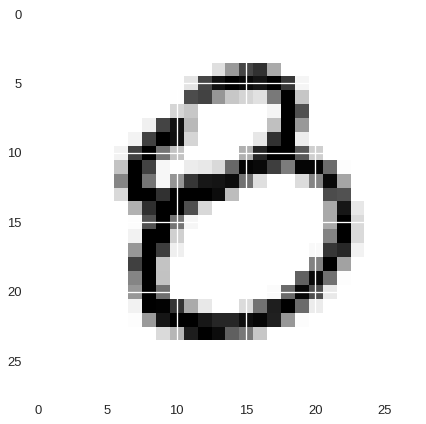

In [41]:
plot_mnist_image(1717, imgs_test_orig, label_test_orig)

Ha predicho un 0. Cuadra.

In [42]:
np.argmax(m.predict(imgs_test_t[1717:1718,]))

0

Ok, but in which positions can we find all the misclassifications? Queremos ver con qué números ha fallado más.

In [43]:
wrong_preds = preds[pos]

wrong_preds[:10]

array([2, 2, 0, 7, 3, 0, 2, 3, 2, 8])

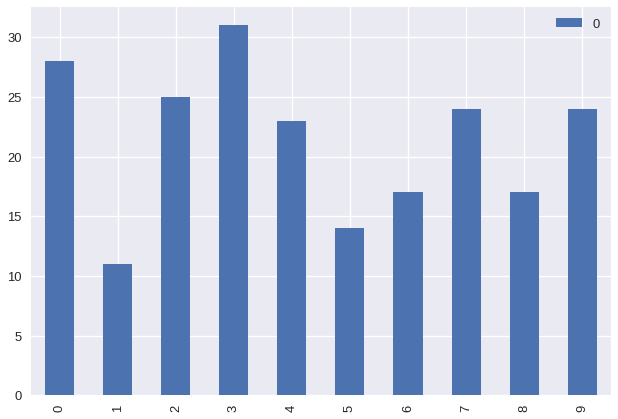

In [44]:
import pandas as pd

s = pd.Series(np.bincount(wrong_preds)).to_frame()

s.plot.bar()

Pero esto no nos vale para ver si mi modelo predice mejor unos u otros, Necesito ver lo balanceadas que están las clases.



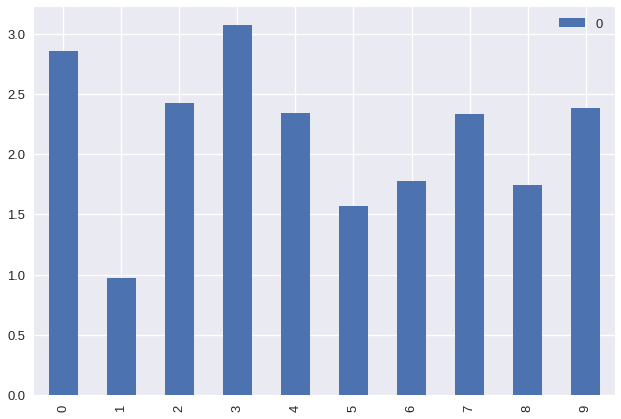

In [45]:
w = pd.Series(np.bincount(wrong_preds))
a = pd.Series(np.bincount(label_test_orig))

p = w/a*100  # para ver en %

p.to_frame().plot.bar()

_**EXERCISE 6**_: Some digits are more difficult to recognize than others. Because we know the test labels, we can find out how many times the corresponding test images are misclassified. Could you find what are the top 3 test labels that are more often misclassified?

Let's check some wrong predictions

The image below should show the number 9


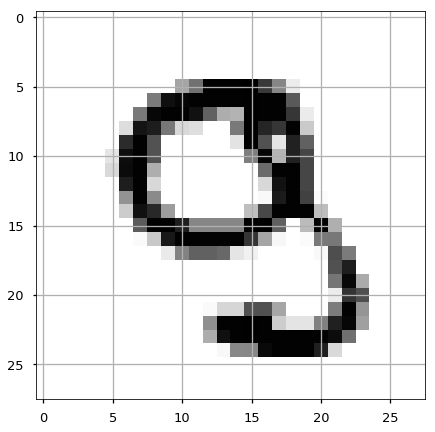

In [0]:
plot_mnist_image(151, test_imgs, test_labels)

In [0]:
preds_labels[151]

8

These are the items that are wrongly classified:

So we see that $9$ is wrongly classified more than the rest. But does it mean that our model has more difficulties recognizing 9s?

Our model has the most difficulties recognizing 9s, 5s and 4s

## Bonus

Vamos a minimizar la parte de modificación de las matrices, etc... con funciones de `keras`.

In [0]:
# Teníamos
# imgs_train_orig
# imgs_test_orig.shape
# label_train_t

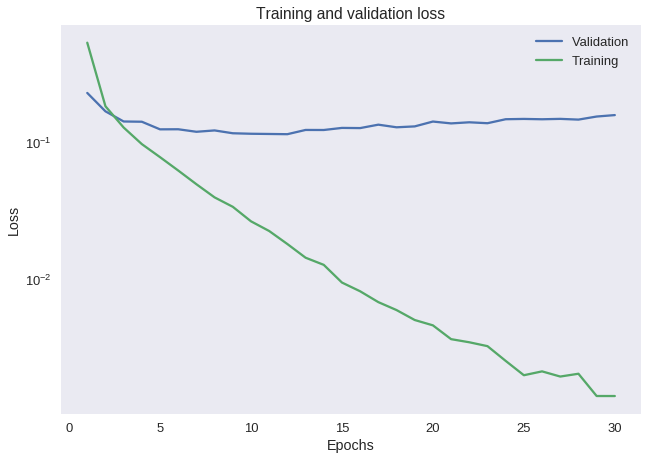

In [101]:
# Construimos el modelo

# Tipo
m = models.Sequential()

# Capas
m.add(layers.Flatten(input_shape=(28,28)))  # añadimos esta capa. No le metemos función de activación porque es un flatten
m.add(layers.BatchNormalization())  # normalizamos
m.add(layers.Dense(128, activation='relu')) 
m.add(layers.Dense(64, activation='relu')) 
m.add(layers.Dense(10, activation='softmax'))  

# Optimizador, loss y métricas
m.compile(
          optimizer=optimizers.rmsprop(), 
          loss=losses.categorical_crossentropy,
          metrics=[metrics.categorical_accuracy])

# Fitteamos
h = m.fit(imgs_train_orig, label_train_t, epochs=30, batch_size=1024, validation_split=.2, verbose=0)

# Plot
plot_metric(h, 'loss')

O sea, siempre que queramos hacer modelos de imágenes con capas densas tendremos que hacer el `Flatten`.

De todas maneras, normalmente para imágenes lo que mejor funciona son las redes convolucionales. Lo veremos.

También hemos normalizado. Lo dicho, con capas muy profundas y gradientes muy grandes (o también muy pequeños) hay problemas numéricos de cálculo, redondeo, overflow...

Hay un paper en la página web de `keras` en el que se explica la utilidad de meter capas intermedias de normalización en redes profundas.

In [102]:
m.evaluate(imgs_test_orig, label_test_t)

10000/10000 [==============================] - 1s 102us/step


[0.16585050362202247, 0.9724]

# Recapitulación

1. Capas: hay que definirlas. También cuidado con las dimensiones de los datos. Si da problemas -> `ìnput_shape`
2. Funciones de activación: casi siempre `relu`. Esta es la primera que hay que probar siempre.
3. Optimizador: esto no tiene mucha influencia. `rmsprop` o `Adam`
4. Función de pérdidas
5. Épocas
6. Batch size

El `validation_size` no es un hiperparámetro.
Siempre dividimos en training y validation, y luego en test.